In [1]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)
pd.options.display.float_format = '{:.2f}'.format


import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gapminder import gapminder 

import datetime
from datetime import datetime as dt
import glob
import os

In [2]:
from pathlib import Path
current_dir = Path.cwd()
current_dir

PosixPath('/Users/keenansmacbookairm3/Documents/GitHub/slate_piece_page')

In [3]:

raw_data_dir = current_dir / 'raw_data'
viz_folder_dir = current_dir/'viz_folder'

In [4]:
df = pd.read_parquet(raw_data_dir/'cash_jordan.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   video_id                    1148 non-null   object 
 1   full_title                  1148 non-null   object 
 2   full_description            1148 non-null   object 
 3   publishedAt                 1148 non-null   object 
 4   video_defaultLanguage       0 non-null      float64
 5   channel_id                  1148 non-null   object 
 6   channel_title               1148 non-null   object 
 7   video_defaultAudioLanguage  1148 non-null   object 
 8   video_categoryId            1148 non-null   object 
 9   video_duration              1148 non-null   object 
 10  video_caption               1148 non-null   object 
 11  video_licensedContent       1148 non-null   bool   
 12  video_viewCount             1148 non-null   object 
 13  video_likeCount             1148 

In [5]:
count_columns = df.columns[df.columns.str.contains('count', case=False)]

df[count_columns] = df[count_columns].apply(pd.to_numeric)

In [6]:
df['publishedDate'] = pd.to_datetime(df.publishedAt).dt.strftime("%Y-%m-%d")
df['publishedMonth'] = pd.to_datetime(df.publishedAt).dt.strftime("%Y-%m")

df.publishedAt = pd.to_datetime(df.publishedAt)


<Axes: xlabel='publishedMonth'>

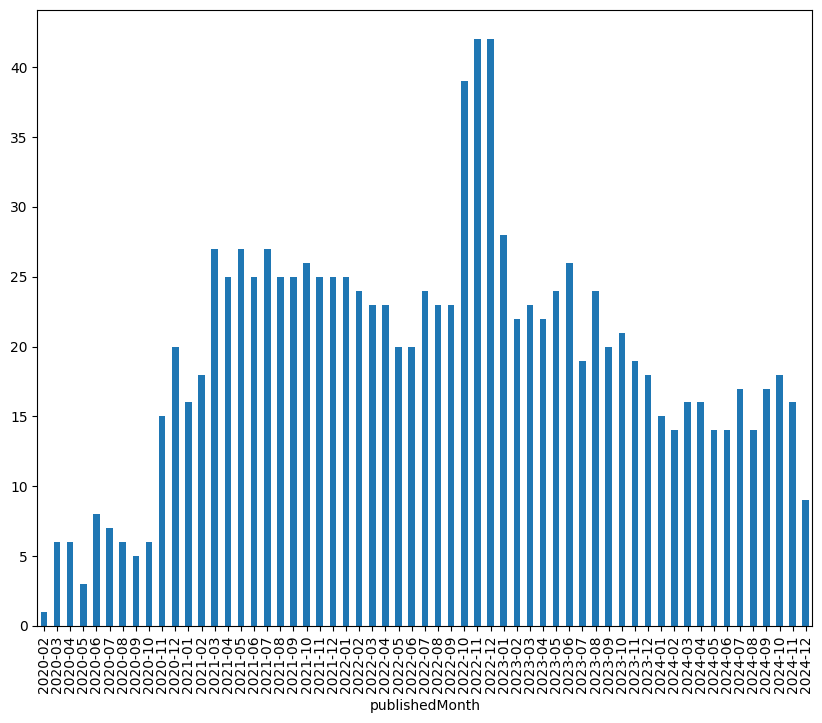

In [7]:
df['publishedMonth'].value_counts(dropna=False).sort_index().plot(kind='bar',
                                                      figsize=(10,8))

<Axes: xlabel='publishedMonth'>

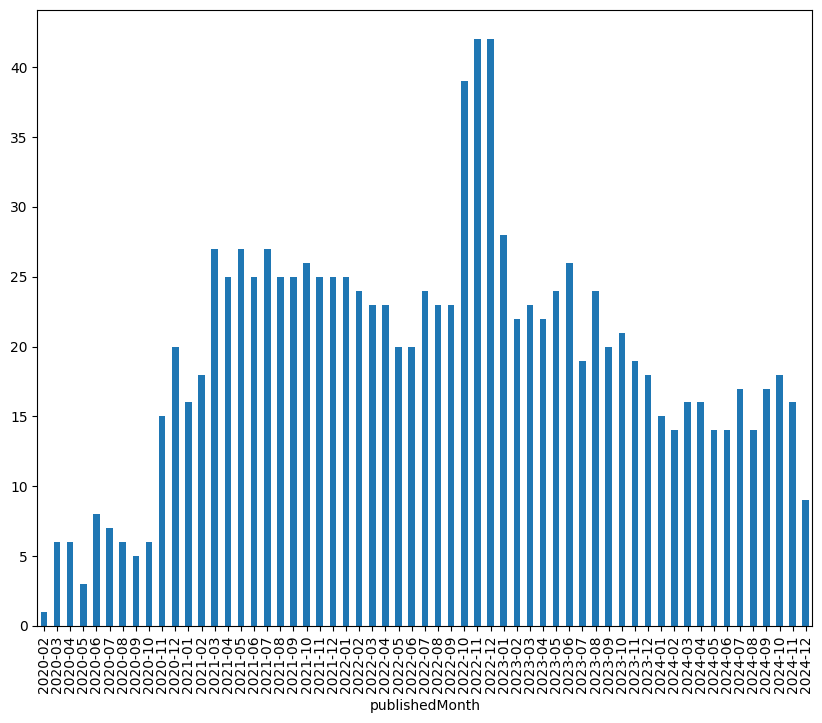

In [8]:
df.publishedMonth.value_counts(dropna=False).sort_index().plot(kind='bar', 
                                                               figsize=(10,8)
                                                               )

In [9]:
import re 
def find_first_paragraph(text):
    first_paragraph = re.search(r'(.+?)(?:\n\s*\n|$)', text, re.DOTALL)
    return first_paragraph.group(1).strip() if first_paragraph else None

In [10]:
df['description_first_paragraph'] = df.full_description.apply(find_first_paragraph)
df['description_first_paragraph'].tail()

1143                                                         Amazing Penthouse with Gorgeous Views of lower Manhattan from the Private Roof Deck.  This apt is in a great locaiton but it has 1 drawback you will see in the video. Hope you like this one - I'd def live here, but would you rent a place like this? Comment below and let me know!
1144           $2000 Challenge! See what will a 2k Budget get you if you want to live in Manhattan!  2 Tours of 2 apartments in the mid $2000's, in downtown Manhattan so you can see what it would be like to live here!  Also, we compare them to the photos posted on listing websites so you can see how these apartments look IRL vs on an App.
1145                                                                              Do you think this 2 bedroom is underpriced or do you think Manhattan is a total ripoff no matter what you end up with? I thought this Lower East Side place was a good find for the $$$ but im curious to hear what you think, so leave a co

In [11]:
df['title+description_first_paragraph'] = df.full_title + " | " + df['description_first_paragraph']

df['title+description_first_paragraph']

0                                                                                                                                                                                                                                                                The Drone Invasion Just Hit NYC... | Residents of NYC are now reporting drone sightings which match the description of those from nearby NJ... yet when the NYPD deploys resources to track them down, they somehow come up empty handed.
1       Terrified Migrants Flee NYC… as 25 Shelters Close | NYC has announced the sudden closure of 25 shelters, panicking residents who thought they'd come to a sanctuary city.  Speaking of which, Mayor Adams is looking for ways of rolling back sanctuary policies that stop NYPD from communicating with ICE to get dangerous individuals off the streets.  Will these polices make the city safer for law abiding immigrants and asylum seekers? Or are critics right in saying this is a mistake?
2                 

In [12]:
import spacy
import nltk
nltk.download('wordnet')
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words) 

from nltk.tokenize import word_tokenize, TweetTokenizer


import contractions
import emoji
import re


url_pattern = re.compile(r'\bhttps?://\S+\b|\bwww\.\S+\b')
email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
mention_pattern = re.compile(r'^(@\w+\s+)+')

def remove_urls(text: str) -> str:
    """Remove URLs from text."""
    return url_pattern.sub('', text)

def remove_emails(text: str) -> str:
    """Remove email addresses from text."""
    return email_pattern.sub('', text)

def remove_last_hashtags(text: str) -> str:
    """Remove hashtags at the end of the text."""
    tokens = [token.lower() for token in TweetTokenizer().tokenize(text)]
    while tokens and tokens[-1].startswith("#"):
        tokens.pop()
    return ' '.join(tokens).strip()



def clean_it_all_up (text, extra_stops):
    # remove emails
    text = remove_emails(text)
    # remove urls
    text = remove_urls(text)
    # remove last hashtags
    text = remove_last_hashtags(text)


    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\n', ' ', text)
    

    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords 
            and (extra_stops is None or token.text.lower() not in extra_stops) 
            # and token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} 
            # and token.ent_type_ not in {'GPE', 'LOC'}
            and token.pos_ not in {"AUX",
                                   "ADP",
                                   "CONJ", 
                                   "CCONJ", 
                                   "DET", 
                                   "INTJ", 
                                   "PART", 
                                   "PUNCT",
                                   "SCONJ", 
                                   "SYM", 
                                   "X", 
                                   "SPACE"}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keenansmacbookairm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [14]:
def ngram_generator(dataframe, date_column,text_column, start_date, end_date, num, extra_stops, top_n=None):

    date_list = date_selection(start_date, end_date)
    cleaned_tokens = ' '.join(
        dataframe[dataframe[date_column].isin(date_list)][text_column]
        .apply(lambda x: clean_it_all_up(str(x), extra_stops) if isinstance(x, str) else '')
        .tolist()
    )
    
    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head(top_n)
    return ngram


In [15]:
dataframe = df
text_column= 'title+description_first_paragraph'
date_column = 'publishedDate'
start_date ='2023-01-01'
end_date ='2024-10-15'
num = 1
extra_stops= ['nyc', 'new york', 'new york city', 'brooklyn', 'bronx', 'manhattan']
top_n=50

top_unigram = ngram_generator(dataframe, date_column,text_column, start_date, end_date, num, extra_stops, top_n)
top_unigram

apartment     361
new           244
city          210
live          187
york          168
tiny           77
house          62
s              60
rent           57
000            54
migrant        54
good           52
asylum         50
place          49
begin          46
small          46
find           45
people         45
get            43
shelter        43
store          43
affordable     38
cool           38
view           37
crime          36
year           36
yorker         35
think          35
seeker         35
want           34
box            34
home           33
build          31
leave          30
little         30
building       29
secret         29
bad            29
look           28
start          27
old            27
big            26
come           26
problem        25
illegal        24
crazy          24
street         23
time           23
need           23
roof           23
Name: count, dtype: int64

In [16]:
dataframe = df
text_column= 'description_first_paragraph'
date_column = 'publishedDate'
start_date ='2023-01-01'
end_date ='2024-10-15'
num = 2
extra_stops= ['nyc', 'new york', 'new york city', 'brooklyn', 'bronx', 'manhattan']
top_n=50

top_bigram = ngram_generator(dataframe, date_column,text_column, start_date, end_date, num, extra_stops, top_n)
top_bigram

(new, york)                139
(york, city)                95
(asylum, seeker)            35
(new, yorker)               23
(cool, apartment)           16
(crazy, apartment)          16
(tiny, house)               15
(little, apartment)         14
(apartment, new)            11
(city, apartment)           11
(year, old)                  9
(live, new)                  9
(empire, state)              8
(affordable, apartment)      8
(apartment, live)            8
(asylum, crisis)             8
(want, live)                 7
(super, cool)                7
(shelter, asylum)            7
(city, new)                  7
(box, apartment)             6
(place, new)                 6
(law, abide)                 6
(shelter, system)            6
(state, building)            6
(city, affordable)           6
(100, year)                  6
(small, apartment)           6
(apartment, perfect)         6
(eric, adams)                5
(insane, view)               5
(incredible, apartment)      5
(d, live

In [17]:
dataframe = df
text_column= 'full_title'
date_column = 'publishedDate'
start_date ='2023-01-01'
end_date ='2024-10-15'
num = 3
extra_stops= ['nyc', 'new york', 'new york city', 'brooklyn', 'bronx', 'manhattan']
top_n=20

top_trigram= ngram_generator(dataframe, date_column,text_column, start_date, end_date, num, extra_stops, top_n)
top_trigram

(new, york, city)                 13
(apartment, good, view)            7
(tiny, house, live)                7
(box, apartment, good)             6
(new, yorker, want)                6
(live, tiny, house)                5
(good, view, live)                 5
(tiny, house, roof)                5
(live, billionaire, secret)        5
(live, box, apartment)             4
(get, bad, shoplifter)             4
(apartment, new, york)             4
(secret, warehouse, apartment)     4
(japanese, tiny, house)            4
(york, city, apartment)            4
(apartment, new, yorker)           4
(city, apartment, small)           3
(live, tiny, box)                  3
(japanese, micro, apartment)       3
(begin, thief, start)              3
Name: count, dtype: int64

In [18]:
df.full_description.str.len().describe()

count   1148.00
mean    1116.89
std      667.13
min        0.00
25%      774.00
50%      903.00
75%     1317.50
max     4049.00
Name: full_description, dtype: float64

In [19]:
df

,video_id,full_title,full_description,publishedAt,video_defaultLanguage,channel_id,channel_title,video_defaultAudioLanguage,video_categoryId,video_duration,video_caption,video_licensedContent,video_viewCount,video_likeCount,video_commentCount,publishedDate,publishedMonth,description_first_paragraph,title+description_first_paragraph
0,vp-ynQZouqc,The Drone Invasion Just Hit NYC...,"Residents of NYC are now reporting drone sightings which match the description of those from nearby NJ... yet when the NYPD deploys resources to track them down, they somehow come up empty handed.\n\nFeudal - Damma Beatz\n\nNeed Music? Get Epidemic Sound: https://www.epidemicsound.com/referral/18oofi\n\n**Everything used to make this video**\n\n[My Camera] https://amzn.to/3VBWywO\n[Mic] https://amzn.to/3ptHhz3\n[Lens] https://amzn.to/3MZGmmF\n[Backpack] https://amzn.to/45pHoP1\n[Handheld Tripod] https://amzn.to/3iUp3Ex \n[Full Size Tripod] https://amzn.to/3cp2sty \n[Lights] https://amzn.to/3izy3ic \n\nGreat news! If you make a purchase from any link above, my channel earns a small affiliate commission from the site.",2024-12-18 14:39:00+00:00,NaN,UCrwbBzP11NhxRUCRKx_BgoQ,Cash Jordan,en-US,22,PT16M6S,false,True,122010,8325,2224,2024-12-18,2024-12,"Residents of NYC are now reporting drone sightings which match the description of those from nearby NJ... yet when the NYPD deploys resources to track them down, they somehow come up empty handed.","The Drone Invasion Just Hit NYC... | Residents of NYC are now reporting drone sightings which match the description of those from nearby NJ... yet when the NYPD deploys resources to track them down, they somehow come up empty handed."
1,QNmduGtotAA,Terrified Migrants Flee NYC… as 25 Shelters Close,"NYC has announced the sudden closure of 25 shelters, panicking residents who thought they'd come to a sanctuary city. Speaking of which, Mayor Adams is looking for ways of rolling back sanctuary policies that stop NYPD from communicating with ICE to get dangerous individuals off the streets. Will these polices make the city safer for law abiding immigrants and asylum seekers? Or are critics right in saying this is a mistake?\n\nTurn the beat up - Baha Bank$\n\nNeed Music? Get Epidemic Sound: https://www.epidemicsound.com/referral/18oofi\n\n**Everything used to make this video**\n\n[My Camera] https://amzn.to/3VBWywO\n[Mic] https://amzn.to/3ptHhz3\n[Lens] https://amzn.to/3MZGmmF\n[Backpack] https://amzn.to/45pHoP1\n[Handheld Tripod] https://amzn.to/3iUp3Ex \n[Full Size Tripod] https://amzn.to/3cp2sty \n[Lights] https://amzn.to/3izy3ic \n\nGreat news! If you make a purchase from any link above, my channel earns a small affiliate commission from the site.",2024-12-17 14:39:00+00:00,NaN,UCrwbBzP11NhxRUCRKx_BgoQ,Cash Jordan,en-US,22,PT16M20S,false,True,171153,10660,2536,2024-12-17,2024-12,"NYC has announced the sudden closure of 25 shelters, panicking residents who thought they'd come to a sanctuary city. Speaking of which, Mayor Adams is looking for ways of rolling back sanctuary policies that stop NYPD from communicating with ICE to get dangerous individuals off the streets. Will these polices make the city safer for law abiding immigrants and asylum seekers? Or are critics right in saying this is a mistake?","Terrified Migrants Flee NYC… as 25 Shelters Close | NYC has announced the sudden closure of 25 shelters, panicking residents who thought they'd come to a sanctuary city. Speaking of which, Mayor Adams is looking for ways of rolling back sanctuary policies that stop NYPD from communicating with ICE to get dangerous individuals off the streets. Will these polices make the city safer for law abiding immigrants and asylum seekers? Or are critics right in saying this is a mistake?"
2,jRaInwDl_ac,Female Gang Raids TJ Maxx… as NYC Gives Up on Theft,"A group of female thieves were caught on camera stealing from a TJ Maxx in Brooklyn NYC. Shockingly, they were armed and started an altercation with a security guard on their w

In [20]:
df[df.video_viewCount == df.video_viewCount.max()]

,video_id,full_title,full_description,publishedAt,video_defaultLanguage,channel_id,channel_title,video_defaultAudioLanguage,video_categoryId,video_duration,video_caption,video_licensedContent,video_viewCount,video_likeCount,video_commentCount,publishedDate,publishedMonth,description_first_paragraph,title+description_first_paragraph
209,AnqUoAEg6f4,NYC is Building Anti-Homeless Streets…,"“Hostile Architecture” has many purposes, but should it be used against NYC’s most vulnerable? There are examples of this type of design all over the city, some by private companies, and others by the city itself.\n\nRuby’s Saga - Ryan James Carr // Working For the Man - Aesyme\n\nNeed Music? Get Epidemic Sound: https://www.epidemicsound.com/referral/18oofi\n\n**Everything used to make this video**\n\n[Camera] https://amzn.to/3VBWywO\n[Mic] https://amzn.to/3ptHhz3\n[Lens] https://amzn.to/3MZGmmF\n[Backpack] https://amzn.to/45pHoP1\n[Handheld Tripod] https://amzn.to/3iUp3Ex \n[Full Size Tripod] https://amzn.to/3cp2sty \n[Lights] https://amzn.to/3izy3ic \n\nGreat news! If you make a purchase from any link above, my channel earns a small affiliate commission from the site.",2023-11-12 14:39:00+00:00,NaN,UCrwbBzP11NhxRUCRKx_BgoQ,Cash Jordan,en-US,22,PT14M27S,false,True,18265175,214876,51926,2023-11-12,2023-11,"“Hostile Architecture” has many purposes, but should it be used against NYC’s most vulnerable? There are examples of this type of design all over the city, some by private companies, and others by the city itself.","NYC is Building Anti-Homeless Streets… | “Hostile Architecture” has many purposes, but should it be used against NYC’s most vulnerable? There are examples of this type of design all over the city, some by private companies, and others by the city itself."


In [21]:
import matplotlib.pyplot as plt


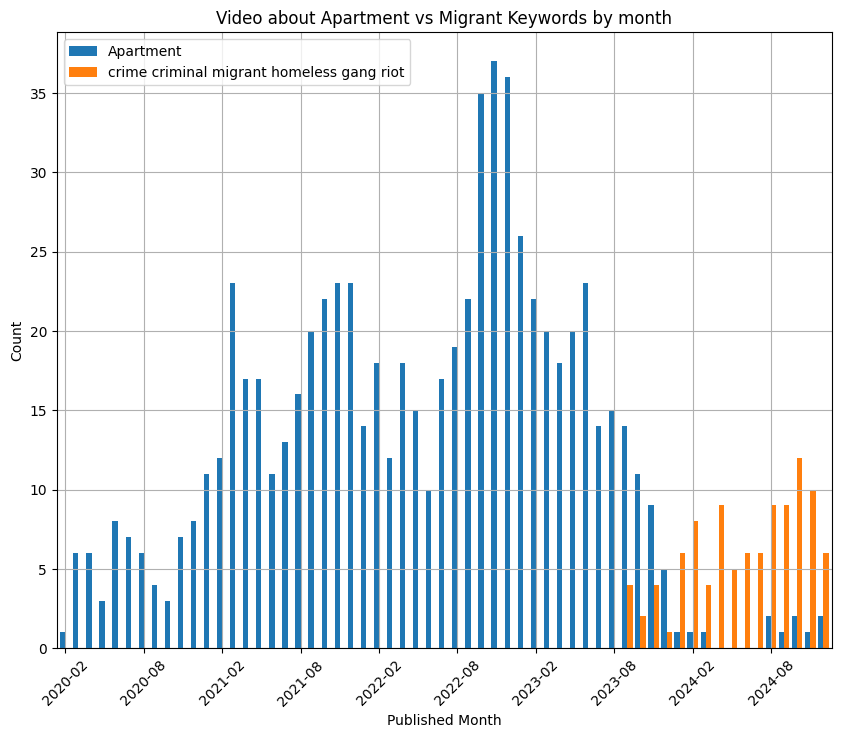

In [22]:

apartment_condo = ['apartment', 'condo', 'rent', 'house']
migrant_crime = ['crime', 'criminal', 'migrant', 'homeless', 'gang', 'riot']

# Get the value counts for 'apartment' and 'migrant' keywords
apartment_counts = df[df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)].publishedMonth.value_counts(dropna=False).sort_index()
migrant_counts = df[df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)].publishedMonth.value_counts(dropna=False).sort_index()

# Combine into one DataFrame
count_df = pd.DataFrame({
    'Apartment': apartment_counts,
    ' '.join(migrant_crime): migrant_counts
}).fillna(0)  # Fill missing months with 0

# Plot
count_df.plot(kind='bar',
              figsize=(10,8), 
              width=0.8
              
             )

unique_months = sorted(df['publishedMonth'].unique())

plt.xticks(
    range(0, len(unique_months), 6), 
    labels=[unique_months[i] for i in range(0, len(unique_months), 6)],
    rotation=45
)
              
plt.title('Video about Apartment vs Migrant Keywords by month')
plt.xlabel('Published Month')
plt.ylabel('Count')
plt.grid(True)
plt.show()


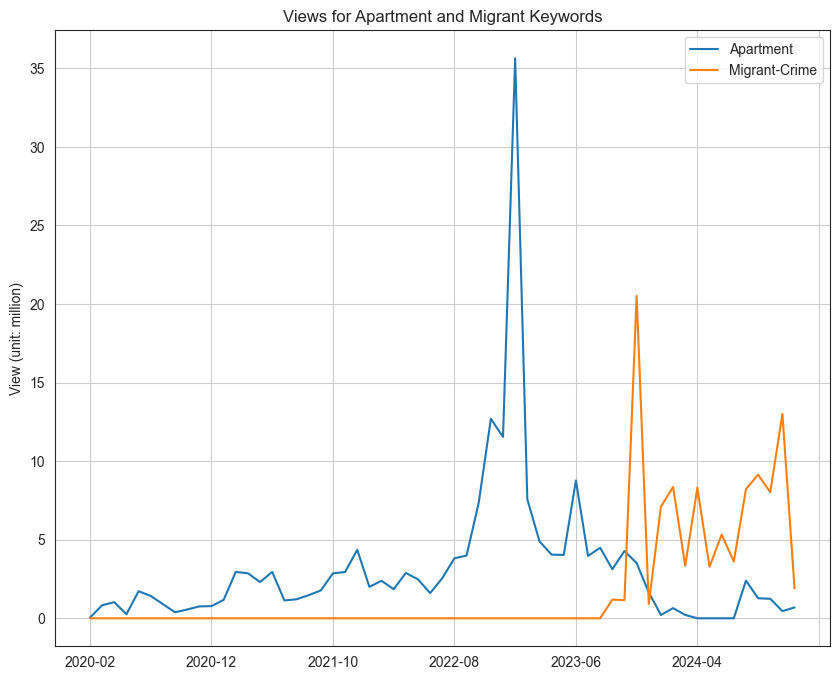

In [23]:
sns.set_style('white')

apartment_view = df[df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)].groupby('publishedMonth').video_viewCount.sum() /1000000
migrant_view = df[df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)].groupby('publishedMonth').video_viewCount.sum() /1000000

# Combine into one DataFrame
view_df = pd.DataFrame({
    'Apartment': apartment_view,
    'Migrant-Crime': migrant_view
}).fillna(0)  # Fill missing months with 0

# Plot
view_df.plot(kind='line',
             figsize=(10,8) 
             )
plt.title('Views for Apartment and Migrant Keywords')
plt.xlabel('')
plt.ylabel('View (unit: million)')
plt.grid(True)
plt.show()


In [24]:
upper_limit = df.video_viewCount.mean() + 3 * df.video_viewCount.std()
lower_limit = df.video_viewCount.mean() -3 * df.video_viewCount.std()
print(f"The upper limit is {upper_limit}")
print(f"The lower limit is {lower_limit}")

The upper limit is 3035160.5187401483
The lower limit is -2331434.53093527


In [25]:
outliers_df = df[df.video_viewCount > upper_limit]

normal_df = df[df.video_viewCount < upper_limit]


outliers_df.shape

(12, 19)

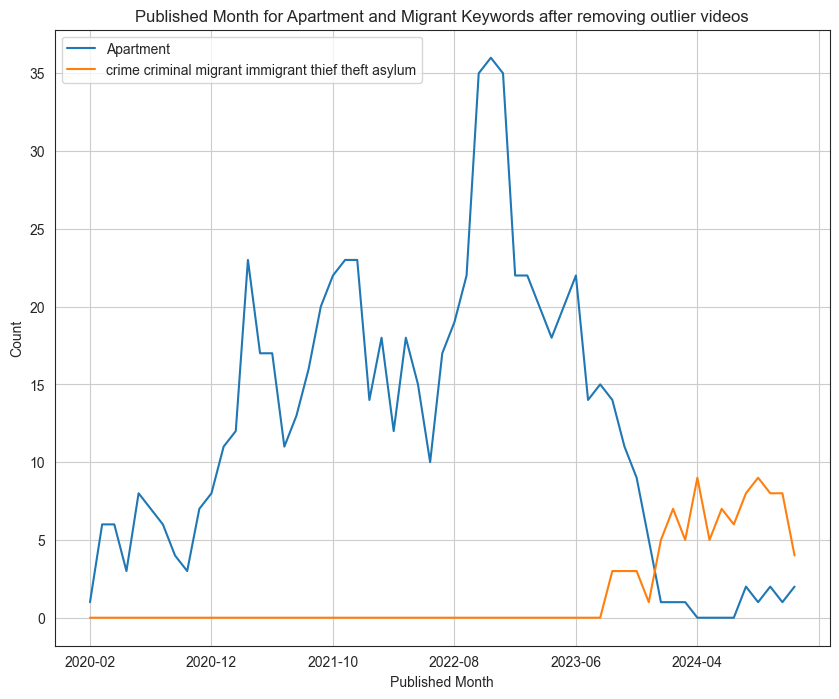

In [26]:
apartment_condo = ['apartment', 'condo', 'rent', 'house']
migrant_crime = ['crime', 'criminal', 'migrant', 'immigrant', 'thief', 'theft', 'asylum']

# Get the value counts for 'apartment' and 'migrant' keywords
apartment_counts = normal_df[normal_df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)].publishedMonth.value_counts(dropna=False).sort_index()
migrant_counts = normal_df[normal_df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)].publishedMonth.value_counts(dropna=False).sort_index()

# Combine into one DataFrame
count_df = pd.DataFrame({
    'Apartment': apartment_counts,
    ' '.join(migrant_crime): migrant_counts
}).fillna(0)  # Fill missing months with 0

# Plot
count_df.plot(kind='line',
              figsize=(10,8) 
             )
              
plt.title('Published Month for Apartment and Migrant Keywords after removing outlier videos')
plt.xlabel('Published Month')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [27]:
normal_df.publishedMonth

0       2024-12
1       2024-12
2       2024-12
3       2024-12
4       2024-12
         ...   
1143    2020-03
1144    2020-03
1145    2020-03
1146    2020-03
1147    2020-02
Name: publishedMonth, Length: 1136, dtype: object

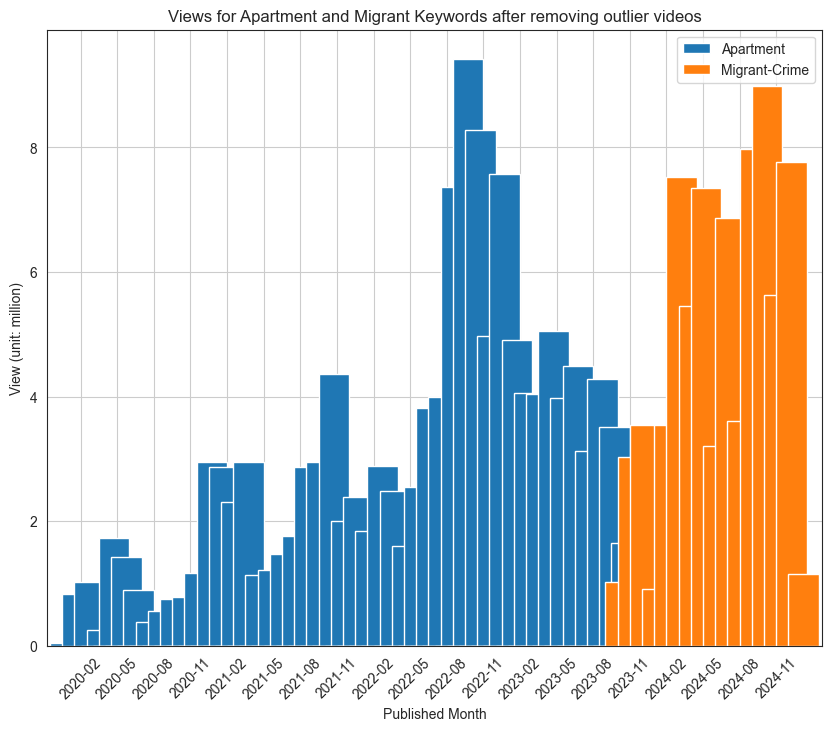

In [28]:

sns.set_style('white')

apartment_view = normal_df[normal_df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)].groupby('publishedMonth').video_viewCount.sum() /1000000
migrant_view = normal_df[normal_df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)].groupby('publishedMonth').video_viewCount.sum() /1000000

# Combine into one DataFrame
view_df = pd.DataFrame({
    'Apartment': apartment_view,
    'Migrant-Crime': migrant_view
}).fillna(0)  # Fill missing months with 0

# Plot
view_df.plot(kind='bar',
             figsize=(10,8),
             width=5
             )

unique_months = sorted(normal_df['publishedMonth'].unique())

plt.xticks(
    range(0, len(unique_months), 3), 
    labels=[unique_months[i] for i in range(0, len(unique_months), 3)],
    rotation=45
)
plt.title('Views for Apartment and Migrant Keywords after removing outlier videos')
plt.xlabel('Published Month')
plt.ylabel('View (unit: million)')
plt.grid(True)
plt.show()


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   video_id                           1148 non-null   object             
 1   full_title                         1148 non-null   object             
 2   full_description                   1148 non-null   object             
 3   publishedAt                        1148 non-null   datetime64[ns, UTC]
 4   video_defaultLanguage              0 non-null      float64            
 5   channel_id                         1148 non-null   object             
 6   channel_title                      1148 non-null   object             
 7   video_defaultAudioLanguage         1148 non-null   object             
 8   video_categoryId                   1148 non-null   object             
 9   video_duration                     1148 non-null   o

In [30]:
df.full_title

0                                                                      The Drone Invasion Just Hit NYC...
1                                                       Terrified Migrants Flee NYC… as 25 Shelters Close
2                                                     Female Gang Raids TJ Maxx… as NYC Gives Up on Theft
3                                                     NYC Starts Giving Away Free Apartments… To Migrants
4                                                        More Renters Go Homeless… As NYC Destroys Itself
                                                      ...                                                
1143                                        $6000 Manhattan Penthouse with Roof Deck | NYC Apartment Tour
1144                                           What will $2000 get you in Manhattan? | NYC Apartment Tour
1145                                     What a $2600 2 Bedroom looks like | Manhattan NYC Apartment Tour
1146                               Brooklyn Ap

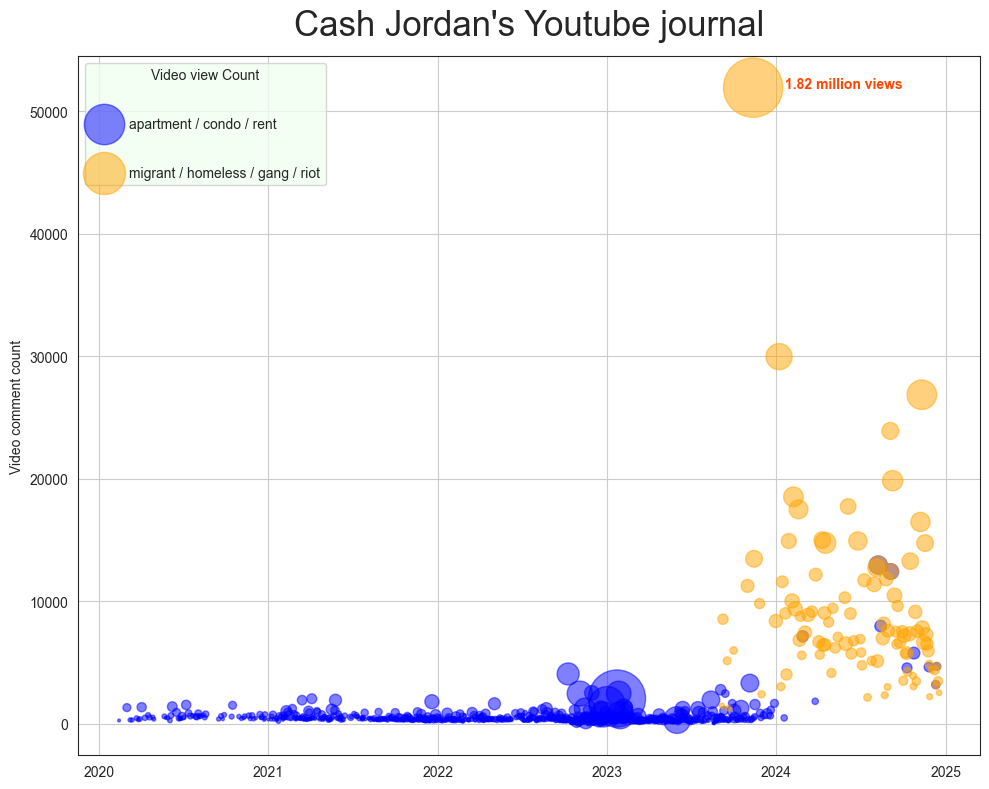

In [31]:
apartment_condo = ['apartment', 'condo', 'rent', 'house']
migrant_crime = ['crime', 'criminal', 'migrant', 'homeless', 'gang', 'riot']

apartment_data = df[df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)]
migrant_data= df[df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)]


sns.set_style('white')

plt.figure(figsize=(10, 8))

plt.scatter(
    apartment_data['publishedAt'],
    apartment_data['video_commentCount'],
    s=apartment_data['video_viewCount'] /10000,
    alpha=0.5,
    label="Apartment Data",
    color='blue'
)


max_migrant_views_index = migrant_data['video_viewCount'].idxmax()
max_migrant_views = migrant_data.loc[max_migrant_views_index]

plt.scatter(
    migrant_data['publishedAt'],
    migrant_data['video_commentCount'],
    s=migrant_data['video_viewCount'] /10000,
    alpha=0.5,
    label="Migrant Data",
    color='orange'
)

plt.annotate(
    f"1.82 million views",
    (max_migrant_views['publishedAt'], max_migrant_views['video_commentCount']),
    textcoords="offset points",
    xytext=(65, 0), 
    ha='center',
    fontsize=10,
    color='orangered',
    fontweight='bold'
)



plt.title("Cash Jordan's Youtube journal", fontsize=25, pad=15)
plt.xlabel('')
plt.ylabel('Video comment count')
plt.legend(
    ['apartment / condo / rent',
     'migrant / homeless / gang / riot'], 
    loc='upper left',
    labelspacing=2.5,
    title="Video view Count",
    facecolor='honeydew'
    )

plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
jordan_subs_data = {
    "20191211": "0K",
    "20221121143109": "369K",
    "20230316025651": "430K",
    "20230330055520": "440K",
    "20230420220605": "467K",
    "20230531115930": "501K",
    "20230816052553": "536K",
    "20230828220218": "544K",
    "20231022004202": "577K",
    "20231108084225": "591K",
    "20231129061320": "648K",
    "20231225214904": "679K",
    "20240126104302": "728K",
    "20240227091435": "783K",
    "20240402183343": "858K",
    "20240503000634": "901K",
    "20240702151547": "957K",
    "20240825191335": "1000K",
    "20240915174042": "1020K",
    "20241217193431": "1100K", 
    "20250314120438": "1260K"
}

jordan_subs_df = pd.DataFrame(
    list(jordan_subs_data.items()),
    columns=["date", "subscriber_count"]
)

jordan_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              21 non-null     object
 1   subscriber_count  21 non-null     object
dtypes: object(2)
memory usage: 468.0+ bytes


In [33]:
from datetime import datetime as dt
jordan_subs_df.date = pd.to_datetime(jordan_subs_df["date"], format="mixed")
jordan_subs_df.date  = jordan_subs_df.date.dt.date



jordan_subs_df.subscriber_count = jordan_subs_df.subscriber_count.str.replace('K', '')
jordan_subs_df.subscriber_count = pd.to_numeric(jordan_subs_df.subscriber_count)

jordan_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              21 non-null     object
 1   subscriber_count  21 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


In [37]:
apartment_data['publishedAt'] = pd.to_datetime(apartment_data['publishedAt']).dt.tz_localize(None)
migrant_data['publishedAt'] = pd.to_datetime(migrant_data['publishedAt']).dt.tz_localize(None)
jordan_subs_df['date'] = pd.to_datetime(jordan_subs_df['date']).dt.tz_localize(None)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_30769/1341447296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apartment_data['publishedAt'] = pd.to_datetime(apartment_data['publishedAt']).dt.tz_localize(None)
/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_30769/1341447296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  migrant_data['publishedAt'] = pd.to_datetime(migrant_data['publishedAt']).dt.tz_localize(None)


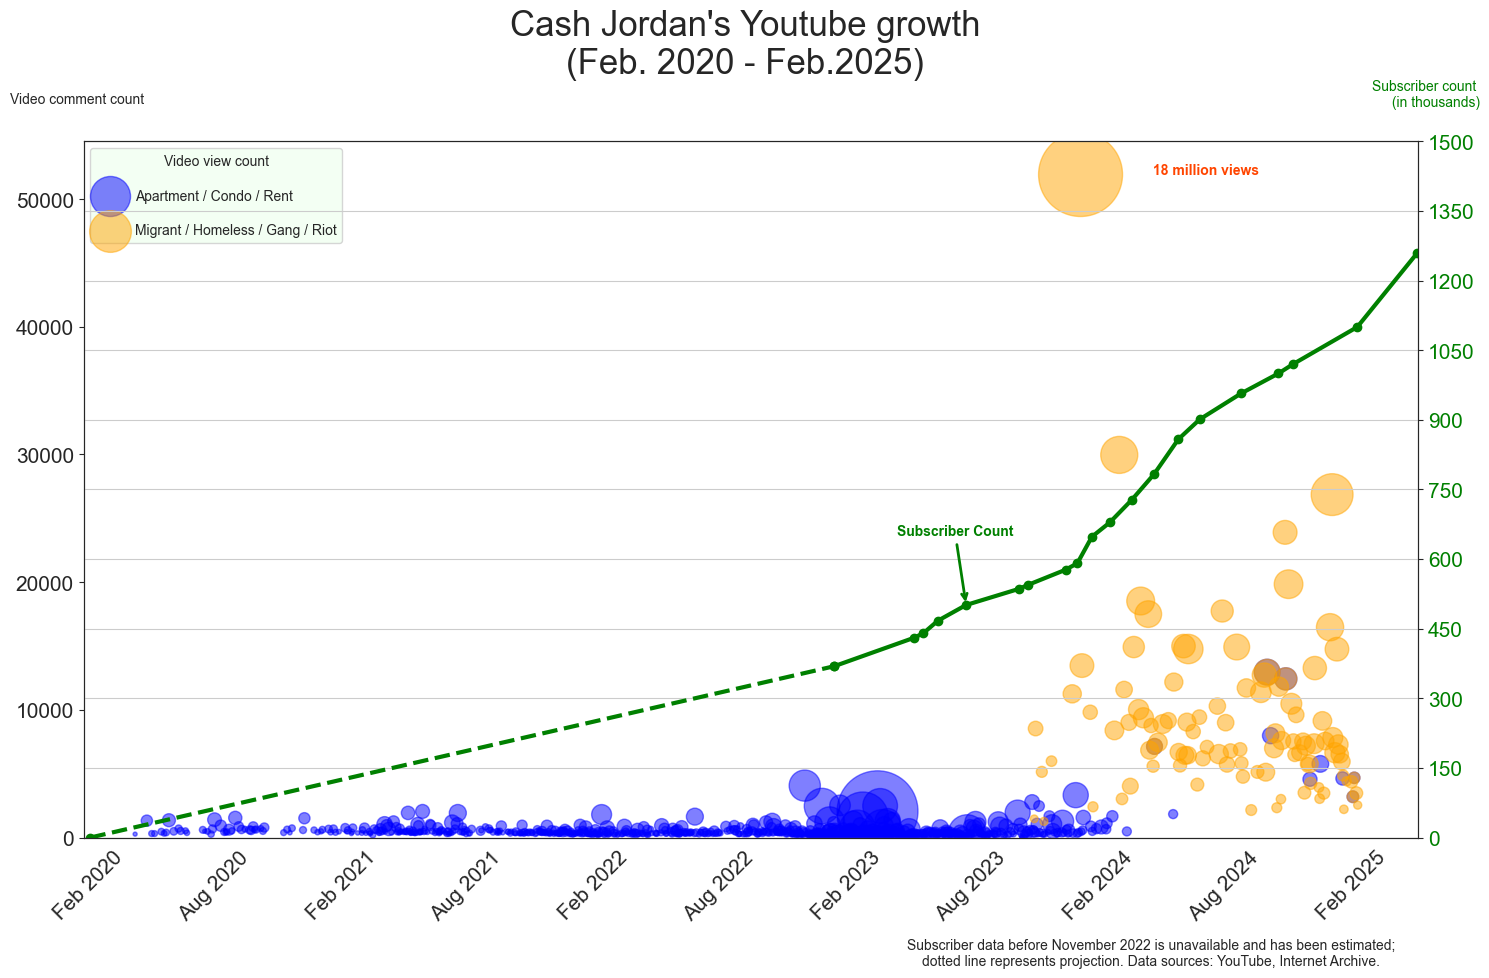

In [144]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime


fig, ax1 = plt.subplots(figsize=(15, 10))

# Scatter plot for apartment data
ax1.scatter(
    apartment_data['publishedAt'],
    apartment_data['video_commentCount'],
    s=apartment_data['video_viewCount'] / 5000,  # Size adjusted by video views
    alpha=0.5,
    label="Apartment Data",
    color='blue'
)

# Scatter plot for migrant data
ax1.scatter(
    migrant_data['publishedAt'],
    migrant_data['video_commentCount'],
    s=migrant_data['video_viewCount'] / 5000,  # Size adjusted by video views
    alpha=0.5,
    label="Migrant Data",
    color='orange'
)

# Set labels for left y-axis
ax1.set_xlabel('')
ax1.set_ylabel('Video comment count',
               fontsize=10,
               rotation='horizontal',
               ha='left',
               position=(1, 1.05) 
               )

# Create second y-axis (ax2) for subscriber count

ax2 = ax1.twinx()

"""ax2.plot(
    jordan_subs_df['date'], 
    jordan_subs_df['subscriber_count'], 
    color='green',
    linewidth=3,
    marker='o'
)"""

ax2.plot(
    jordan_subs_df['date'][:2], 
    jordan_subs_df['subscriber_count'][:2], 
    color='green',
    ls='--',
    linewidth=3,
    marker='o'
)

ax2.plot(
    jordan_subs_df['date'][1:], 
    jordan_subs_df['subscriber_count'][1:], 
    color='green',
    ls='-',
    linewidth=3,
    marker='o'
)

ax2.set_ylabel('Subscriber count \n (in thousands)', 
               color='green',
               fontsize=10,
               rotation='horizontal',
               ha='right',
               position=(1, 1.09) 
)
ax2.set_ylim(0, 1500)  
ax2.set_yticks(range(0, 1501, 150))  
ax2.tick_params(axis='y', labelcolor='green')




# Set both y-axes to start from 0
ax1.set_ylim(bottom=0)  # Make sure left y-axis starts from 0
ax2.set_ylim(0, 1500)   # Ensure right y-axis starts at 0 and ends at 1500

# Ensure that the x-axis is the same for both axes
ax1.set_xlim(datetime.datetime(2019, 12, 1), datetime.datetime(2025, 3, 15))

# Format the x-axis to display months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formatter for month and year

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

max_migrant_views_index = migrant_data['video_viewCount'].idxmax()
max_migrant_views = migrant_data.loc[max_migrant_views_index]

ax1.annotate(
    f"18 million views",
    (max_migrant_views['publishedAt'], max_migrant_views['video_commentCount']),
    textcoords="offset points",
    xytext=(90, 0), 
    ha='center',
    fontsize=10,
    color='orangered',
    fontweight='bold'
)

mid_index = len(jordan_subs_df) // 4
mid_date = jordan_subs_df['date'].iloc[mid_index]
mid_subscriber_count = jordan_subs_df['subscriber_count'].iloc[mid_index]

# Annotation for the subscriber count line (at the midpoint)
ax2.annotate(
    "Subscriber Count", 
    xy=(mid_date, mid_subscriber_count),  # Point to the midpoint of the line plot
    xytext=(-50, 50),  # Position of the text relative to the midpoint
    textcoords="offset points", 
    arrowprops=dict(arrowstyle="->", color="green", lw=2),  # Arrow pointing to the line
    fontsize=10, 
    color="green", 
    fontweight="bold"
)




# Set legend
ax1.legend(
    ['Apartment / Condo / Rent', 
     'Migrant / Homeless / Gang / Riot'], 
     markerscale=0.7,
    loc='upper left',
    labelspacing=1.5,
    title="Video view count",
    facecolor='honeydew',
    fontsize=10, 
    title_fontsize=10
)
ax2.annotate(
    "Subscriber data before November 2022 is unavailable and has been estimated;\n" \
    "dotted line represents projection. Data sources: YouTube, Internet Archive.",
    xy=(0.8, -0.18), 
    xycoords='axes fraction',  
    ha='center',  
    fontsize=10,
    wrap=True
)


plt.grid(True)
plt.subplots_adjust(bottom=0.15) 

plt.suptitle("Cash Jordan's Youtube growth\n(Feb. 2020 - Feb.2025)", fontsize=25)


plt.tight_layout()
plt.savefig(f"{viz_folder_dir}/cash_jordan_youtube_metrics.jpeg", dpi=600)

plt.show()
